### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [1]:
import sys
sys.path.append("../..")

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data_vmd(df, _K=6)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

## CNN-BiLSTM

In [5]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
model = CNNBiLSTM(input_dim=len(features))

In [8]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [9]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [10]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 192261
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 43.70it/s]


Epoch [1/500] - Train Loss: 1.181956, Val Loss: 21.347528
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.75it/s]


Epoch [2/500] - Train Loss: 0.996563, Val Loss: 19.612165
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 293.22it/s]


Epoch [3/500] - Train Loss: 0.814181, Val Loss: 16.822258
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.38it/s]


Epoch [4/500] - Train Loss: 0.610117, Val Loss: 12.452167
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.27it/s]


Epoch [5/500] - Train Loss: 0.367840, Val Loss: 6.598046
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.05it/s]


Epoch [6/500] - Train Loss: 0.224600, Val Loss: 3.077869
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.90it/s]


Epoch [7/500] - Train Loss: 0.091847, Val Loss: 1.729824
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.73it/s]


Epoch [8/500] - Train Loss: 0.048060, Val Loss: 0.452749
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 301.43it/s]


Epoch [9/500] - Train Loss: 0.033552, Val Loss: 0.342524
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 293.26it/s]


Epoch [10/500] - Train Loss: 0.022203, Val Loss: 0.274353
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.49it/s]


Epoch [11/500] - Train Loss: 0.016669, Val Loss: 0.252063
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.93it/s]


Epoch [12/500] - Train Loss: 0.013891, Val Loss: 0.307783
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.34it/s]


Epoch [13/500] - Train Loss: 0.016639, Val Loss: 0.328451
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.54it/s]


Epoch [14/500] - Train Loss: 0.075743, Val Loss: 1.080402
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 303.45it/s]


Epoch [15/500] - Train Loss: 0.215870, Val Loss: 1.554351
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.60it/s]


Epoch [16/500] - Train Loss: 0.058339, Val Loss: 1.088934
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 298.34it/s]


Epoch [17/500] - Train Loss: 0.022684, Val Loss: 0.412014
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.49it/s]


Epoch [18/500] - Train Loss: 0.027455, Val Loss: 0.355919
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.11it/s]


Epoch [19/500] - Train Loss: 0.018323, Val Loss: 0.527020
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.72it/s]


Epoch [20/500] - Train Loss: 0.015982, Val Loss: 0.484093
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.75it/s]


Epoch [21/500] - Train Loss: 0.014235, Val Loss: 0.434638
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.67it/s]


Epoch [22/500] - Train Loss: 0.012763, Val Loss: 0.546126
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.71it/s]


Epoch [23/500] - Train Loss: 0.011419, Val Loss: 0.490097
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.44it/s]


Epoch [24/500] - Train Loss: 0.009873, Val Loss: 0.538574
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.10it/s]


Epoch [25/500] - Train Loss: 0.009939, Val Loss: 0.517917
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 292.01it/s]


Epoch [26/500] - Train Loss: 0.009616, Val Loss: 0.673811
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.85it/s]


Epoch [27/500] - Train Loss: 0.008579, Val Loss: 0.512617
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.02it/s]


Epoch [28/500] - Train Loss: 0.010073, Val Loss: 0.675674
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 312.90it/s]


Epoch [29/500] - Train Loss: 0.012089, Val Loss: 0.458030
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.46it/s]


Epoch [30/500] - Train Loss: 0.020444, Val Loss: 1.017479
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.75it/s]


Epoch [31/500] - Train Loss: 0.041076, Val Loss: 0.244482
Epoch 32/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.44it/s]


Epoch [32/500] - Train Loss: 0.065013, Val Loss: 1.681615
Epoch 33/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 313.00it/s]


Epoch [33/500] - Train Loss: 0.059249, Val Loss: 0.269911
Epoch 34/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.34it/s]


Epoch [34/500] - Train Loss: 0.023741, Val Loss: 1.069320
Epoch 35/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.76it/s]


Epoch [35/500] - Train Loss: 0.010324, Val Loss: 0.466456
Epoch 36/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.40it/s]


Epoch [36/500] - Train Loss: 0.010952, Val Loss: 0.463741
Epoch 37/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 310.18it/s]


Epoch [37/500] - Train Loss: 0.010234, Val Loss: 0.655480
Epoch 38/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.20it/s]


Epoch [38/500] - Train Loss: 0.009135, Val Loss: 0.510940
Epoch 39/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.52it/s]


Epoch [39/500] - Train Loss: 0.008105, Val Loss: 0.558469
Epoch 40/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.55it/s]


Epoch [40/500] - Train Loss: 0.007424, Val Loss: 0.557157
Epoch 41/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.97it/s]


Epoch [41/500] - Train Loss: 0.007760, Val Loss: 0.562813
Epoch 42/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.04it/s]


Epoch [42/500] - Train Loss: 0.007018, Val Loss: 0.547595
Epoch 43/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.75it/s]


Epoch [43/500] - Train Loss: 0.006560, Val Loss: 0.593278
Epoch 44/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.69it/s]


Epoch [44/500] - Train Loss: 0.007793, Val Loss: 0.516785
Epoch 45/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.57it/s]


Epoch [45/500] - Train Loss: 0.007847, Val Loss: 0.640356
Epoch 46/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 274.16it/s]


Epoch [46/500] - Train Loss: 0.008958, Val Loss: 0.409457
Epoch 47/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.86it/s]


Epoch [47/500] - Train Loss: 0.012297, Val Loss: 0.809289
Epoch 48/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.65it/s]


Epoch [48/500] - Train Loss: 0.020401, Val Loss: 0.265032
Epoch 49/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.02it/s]


Epoch [49/500] - Train Loss: 0.034416, Val Loss: 1.270110
Epoch 50/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 320.05it/s]


Epoch [50/500] - Train Loss: 0.053429, Val Loss: 0.195028
Epoch 51/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.46it/s]


Epoch [51/500] - Train Loss: 0.045416, Val Loss: 1.547539
Epoch 52/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.73it/s]


Epoch [52/500] - Train Loss: 0.029247, Val Loss: 0.242240
Epoch 53/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 274.84it/s]


Epoch [53/500] - Train Loss: 0.012306, Val Loss: 0.848697
Epoch 54/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.81it/s]


Epoch [54/500] - Train Loss: 0.008669, Val Loss: 0.507584
Epoch 55/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.36it/s]


Epoch [55/500] - Train Loss: 0.007843, Val Loss: 0.522729
Epoch 56/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.93it/s]


Epoch [56/500] - Train Loss: 0.007045, Val Loss: 0.614665
Epoch 57/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.43it/s]


Epoch [57/500] - Train Loss: 0.005962, Val Loss: 0.540911
Epoch 58/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.97it/s]


Epoch [58/500] - Train Loss: 0.006299, Val Loss: 0.531743
Epoch 59/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.97it/s]


Epoch [59/500] - Train Loss: 0.006266, Val Loss: 0.583990
Epoch 60/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 298.76it/s]


Epoch [60/500] - Train Loss: 0.006085, Val Loss: 0.555814
Epoch 61/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.44it/s]


Epoch [61/500] - Train Loss: 0.005153, Val Loss: 0.564861
Epoch 62/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.43it/s]


Epoch [62/500] - Train Loss: 0.005747, Val Loss: 0.527736
Epoch 63/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.58it/s]


Epoch [63/500] - Train Loss: 0.005345, Val Loss: 0.553703
Epoch 64/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 278.66it/s]


Epoch [64/500] - Train Loss: 0.005852, Val Loss: 0.461516
Epoch 65/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.87it/s]


Epoch [65/500] - Train Loss: 0.005343, Val Loss: 0.550945
Epoch 66/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.78it/s]


Epoch [66/500] - Train Loss: 0.005263, Val Loss: 0.466959
Epoch 67/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.43it/s]


Epoch [67/500] - Train Loss: 0.005858, Val Loss: 0.588854
Epoch 68/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.95it/s]


Epoch [68/500] - Train Loss: 0.009276, Val Loss: 0.341476
Epoch 69/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.32it/s]


Epoch [69/500] - Train Loss: 0.020569, Val Loss: 0.974522
Epoch 70/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.43it/s]


Epoch [70/500] - Train Loss: 0.042869, Val Loss: 0.181237
Epoch 71/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.73it/s]


Epoch [71/500] - Train Loss: 0.064917, Val Loss: 1.630732
Epoch 72/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.15it/s]


Epoch [72/500] - Train Loss: 0.073900, Val Loss: 0.290774
Epoch 73/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 305.26it/s]


Epoch [73/500] - Train Loss: 0.029716, Val Loss: 1.337802
Epoch 74/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 272.78it/s]


Epoch [74/500] - Train Loss: 0.012209, Val Loss: 0.461216
Epoch 75/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.07it/s]


Epoch [75/500] - Train Loss: 0.008798, Val Loss: 0.608566
Epoch 76/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 306.97it/s]


Epoch [76/500] - Train Loss: 0.008026, Val Loss: 0.760805
Epoch 77/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.78it/s]


Epoch [77/500] - Train Loss: 0.007267, Val Loss: 0.578139
Epoch 78/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.45it/s]


Epoch [78/500] - Train Loss: 0.006122, Val Loss: 0.718702
Epoch 79/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.41it/s]


Epoch [79/500] - Train Loss: 0.005969, Val Loss: 0.688722
Epoch 80/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.95it/s]


Epoch [80/500] - Train Loss: 0.006566, Val Loss: 0.651303
Epoch 81/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.03it/s]


Epoch [81/500] - Train Loss: 0.005356, Val Loss: 0.699545
Epoch 82/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 198.79it/s]


Epoch [82/500] - Train Loss: 0.005548, Val Loss: 0.623896
Epoch 83/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.49it/s]


Epoch [83/500] - Train Loss: 0.005151, Val Loss: 0.657941
Epoch 84/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 305.48it/s]


Epoch [84/500] - Train Loss: 0.004989, Val Loss: 0.611690
Epoch 85/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 298.91it/s]


Epoch [85/500] - Train Loss: 0.004953, Val Loss: 0.641269
Epoch 86/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.84it/s]


Epoch [86/500] - Train Loss: 0.004521, Val Loss: 0.595693
Epoch 87/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.15it/s]


Epoch [87/500] - Train Loss: 0.004611, Val Loss: 0.615875
Epoch 88/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.42it/s]


Epoch [88/500] - Train Loss: 0.005116, Val Loss: 0.521660
Epoch 89/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.00it/s]


Epoch [89/500] - Train Loss: 0.005242, Val Loss: 0.631219
Epoch 90/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.08it/s]


Epoch [90/500] - Train Loss: 0.008909, Val Loss: 0.423454
Epoch 91/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.21it/s]


Epoch [91/500] - Train Loss: 0.022335, Val Loss: 1.024842
Epoch 92/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.01it/s]


Epoch [92/500] - Train Loss: 0.035646, Val Loss: 0.173069
Epoch 93/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 302.89it/s]


Epoch [93/500] - Train Loss: 0.039756, Val Loss: 1.380546
Epoch 94/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.23it/s]


Epoch [94/500] - Train Loss: 0.033956, Val Loss: 0.196404
Epoch 95/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.56it/s]


Epoch [95/500] - Train Loss: 0.017861, Val Loss: 1.028908
Epoch 96/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.52it/s]


Epoch [96/500] - Train Loss: 0.009779, Val Loss: 0.409593
Epoch 97/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.24it/s]


Epoch [97/500] - Train Loss: 0.006910, Val Loss: 0.596999
Epoch 98/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.69it/s]


Epoch [98/500] - Train Loss: 0.005906, Val Loss: 0.572657
Epoch 99/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 292.87it/s]


Epoch [99/500] - Train Loss: 0.005247, Val Loss: 0.534170
Epoch 100/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.86it/s]


Epoch [100/500] - Train Loss: 0.004839, Val Loss: 0.537426
Epoch 101/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 317.86it/s]


Epoch [101/500] - Train Loss: 0.004829, Val Loss: 0.573486
Epoch 102/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 315.86it/s]


Epoch [102/500] - Train Loss: 0.004604, Val Loss: 0.508817
Epoch 103/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.37it/s]


Epoch [103/500] - Train Loss: 0.004454, Val Loss: 0.506622
Epoch 104/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.02it/s]


Epoch [104/500] - Train Loss: 0.004456, Val Loss: 0.492789
Epoch 105/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.88it/s]


Epoch [105/500] - Train Loss: 0.004146, Val Loss: 0.394751
Epoch 106/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 299.18it/s]


Epoch [106/500] - Train Loss: 0.005728, Val Loss: 0.555382
Epoch 107/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.86it/s]


Epoch [107/500] - Train Loss: 0.008316, Val Loss: 0.298261
Epoch 108/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 303.40it/s]


Epoch [108/500] - Train Loss: 0.017658, Val Loss: 1.016499
Epoch 109/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 299.72it/s]


Epoch [109/500] - Train Loss: 0.023671, Val Loss: 0.225466
Epoch 110/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.24it/s]


Epoch [110/500] - Train Loss: 0.026150, Val Loss: 1.190496
Epoch 111/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 292.22it/s]


Epoch [111/500] - Train Loss: 0.022575, Val Loss: 0.228697
Epoch 112/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.37it/s]


Epoch [112/500] - Train Loss: 0.013546, Val Loss: 0.952642
Epoch 113/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.47it/s]


Epoch [113/500] - Train Loss: 0.010047, Val Loss: 0.396680
Epoch 114/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.81it/s]


Epoch [114/500] - Train Loss: 0.005954, Val Loss: 0.654383
Epoch 115/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.93it/s]


Epoch [115/500] - Train Loss: 0.004883, Val Loss: 0.527263
Epoch 116/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.40it/s]


Epoch [116/500] - Train Loss: 0.004351, Val Loss: 0.559390
Epoch 117/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 278.91it/s]


Epoch [117/500] - Train Loss: 0.004651, Val Loss: 0.545013
Epoch 118/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.72it/s]


Epoch [118/500] - Train Loss: 0.004356, Val Loss: 0.572096
Epoch 119/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.90it/s]


Epoch [119/500] - Train Loss: 0.004301, Val Loss: 0.551388
Epoch 120/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 278.40it/s]


Epoch [120/500] - Train Loss: 0.003643, Val Loss: 0.602122
Epoch 121/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.00it/s]


Epoch [121/500] - Train Loss: 0.004008, Val Loss: 0.547354
Epoch 122/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 272.68it/s]

Epoch [122/500] - Train Loss: 0.003996, Val Loss: 0.620122
Early stopping triggered after epoch 122

Best validation loss: 0.173069


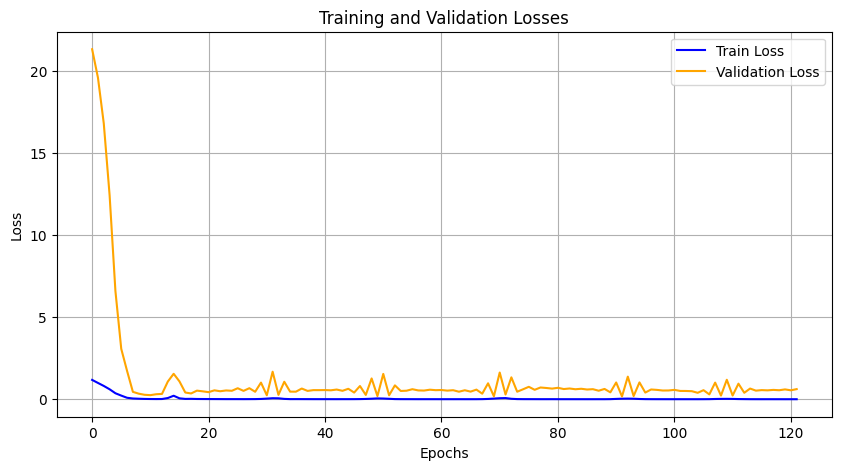

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.276682


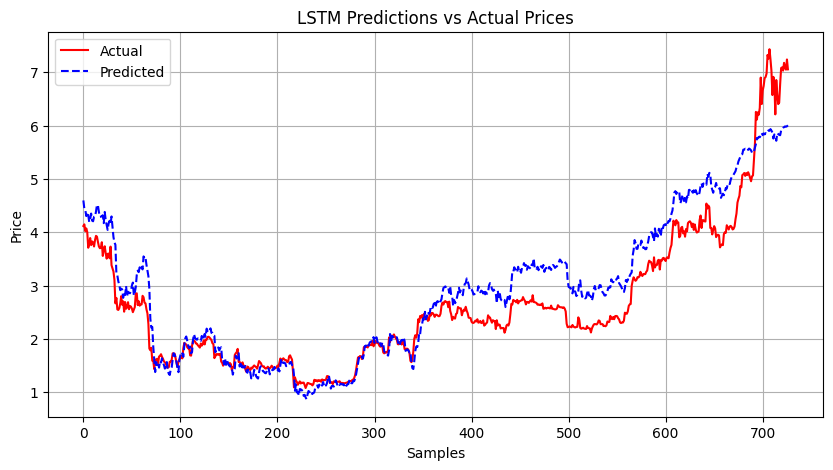

In [13]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()

In [14]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, conv_filters=96, conv_kernel=3, lstm_hidden=12, num_bilstm_layers=2, attn_heads=4, attn_dim=64, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden, num_layers=num_bilstm_layers, batch_first=True, bidirectional=True)
        # Use PyTorch MultiheadAttention: needs embedding dim. We'll map BiLSTM outputs to attn_dim
        self.proj = nn.Linear(2*lstm_hidden, attn_dim)
        self.attn = nn.MultiheadAttention(embed_dim=attn_dim, num_heads=attn_heads, batch_first=True)
        self.out_fc = nn.Sequential(
            nn.Linear(attn_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: B,T,F
        x = x.permute(0,2,1)              # B,F,T
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.permute(0,2,1)              # B,T,conv_filters
        x = self.dropout(x)
        out, _ = self.bilstm(x)           # B,T,2*lstm_hidden
        proj = self.proj(out)             # B,T,attn_dim
        # MultiheadAttention expects (B, T, E) if batch_first=True
        attn_out, _ = self.attn(proj, proj, proj)  # self-attention
        # Pool (use last time step or mean)
        pooled = attn_out.mean(dim=1)     # B, attn_dim
        out = self.out_fc(pooled)         # B,1
        return out.squeeze(-1)


In [15]:
model2 = CNN_BiLSTM_Attention(input_dim=len(features))

In [16]:
model2 = model2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [17]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model2.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model2.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model2.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model2(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 68545
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 34.95it/s]


Epoch [1/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 272.22it/s]


Epoch [2/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.68it/s]


Epoch [3/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.03it/s]


Epoch [4/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.20it/s]


Epoch [5/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.40it/s]


Epoch [6/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.13it/s]


Epoch [7/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.98it/s]


Epoch [8/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.95it/s]


Epoch [9/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.67it/s]


Epoch [10/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.26it/s]


Epoch [11/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.56it/s]


Epoch [12/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 254.13it/s]


Epoch [13/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.79it/s]


Epoch [14/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.42it/s]


Epoch [15/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.82it/s]


Epoch [16/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.77it/s]


Epoch [17/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.38it/s]


Epoch [18/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.20it/s]


Epoch [19/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.75it/s]


Epoch [20/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.02it/s]


Epoch [21/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.31it/s]


Epoch [22/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.14it/s]


Epoch [23/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 253.33it/s]


Epoch [24/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.85it/s]


Epoch [25/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.82it/s]


Epoch [26/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.62it/s]


Epoch [27/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.05it/s]


Epoch [28/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.24it/s]


Epoch [29/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.56it/s]


Epoch [30/500] - Train Loss: 1.072825, Val Loss: 19.453763
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.04it/s]

Epoch [31/500] - Train Loss: 1.072825, Val Loss: 19.453763
Early stopping triggered after epoch 31

Best validation loss: 19.453763
